In [1]:
#This file is only looking at the roster plots for old organoid data
import networkx as nx
import numpy as np
import pickle
import pandas as pd
from scipy.io import loadmat
import h5py
from scipy.ndimage import gaussian_filter
from scipy.signal import correlate, gaussian
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
import itertools
from pathlib import Path
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt

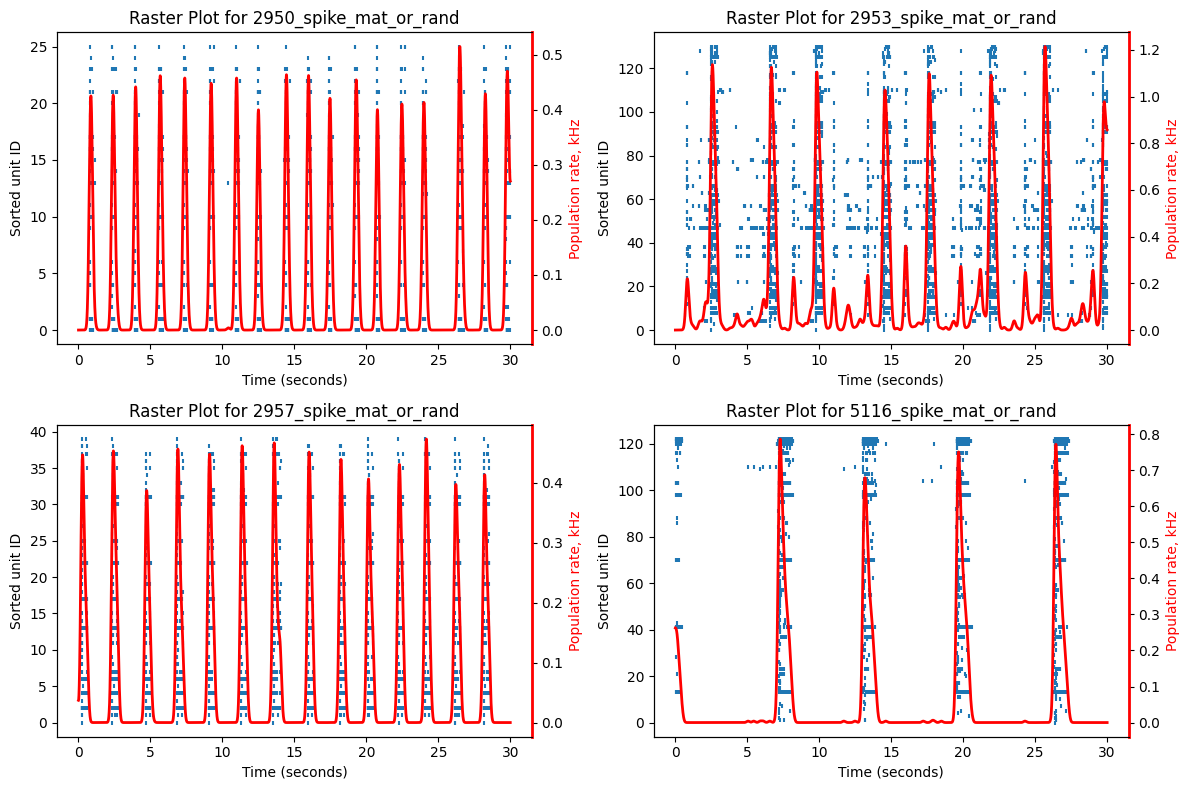

In [4]:
ALL_FILES = [
    "2950_spike_mat_or_rand", #26
    "2953_spike_mat_or_rand", #Tal paper
    "2957_spike_mat_or_rand",
    "5116_spike_mat_or_rand",
]
# Load your .mat file

"""
# Raster plots for 3 min of recording

# Parameters:
# - spike_times: 2D array-like, where each row represents a time unit and each column a neuron.
# - units: int, total number of time units.
# - unit_duration_ms: int, duration of each time unit in milliseconds.
# - total_minutes: int, total time span in minutes.
# """

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for idx, fn in enumerate(ALL_FILES):
    data = loadmat(f"{fn}.mat")

    # Extracting all variables from the .mat file
    t_spk_mat = data['t_spk_mat']
    t_spk_mat_rand = data['t_spk_mat_rand']

    # Creating DataFrames for each variable
    df_t_spk_mat = pd.DataFrame(t_spk_mat)
    df_t_spk_mat_rand = pd.DataFrame(t_spk_mat_rand)

    # Plotting the raster plot and average spikes per unit
    ax = axs[idx // 2, idx % 2]
    spike_indices = t_spk_mat[:30*1000].nonzero()
    ax.scatter(spike_indices[0] / 1000.0, spike_indices[1], marker='|', s=10)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Sorted unit ID')
    ax.set_title(f"Raster Plot for {fn}")

    avg_spikes = np.sum(t_spk_mat, axis=1)[:30*1000]
    avg_spikes = avg_spikes.astype(float)
    avg_spikes_smooth = gaussian_filter1d(avg_spikes, 100)

    ax2 = ax.twinx()
    xs = np.linspace(0, len(avg_spikes), len(avg_spikes)) / 1000.0
    ax2.plot(xs, avg_spikes_smooth, color='red', linewidth=2)
    ax2.yaxis.label.set_color('red')
    ax2.set_ylabel('Population rate, kHz')
    ax2.spines['right'].set_color('red')
    ax2.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.show()


   



ValueError: x and y must have same first dimension, but have shapes (2,) and (30000,)

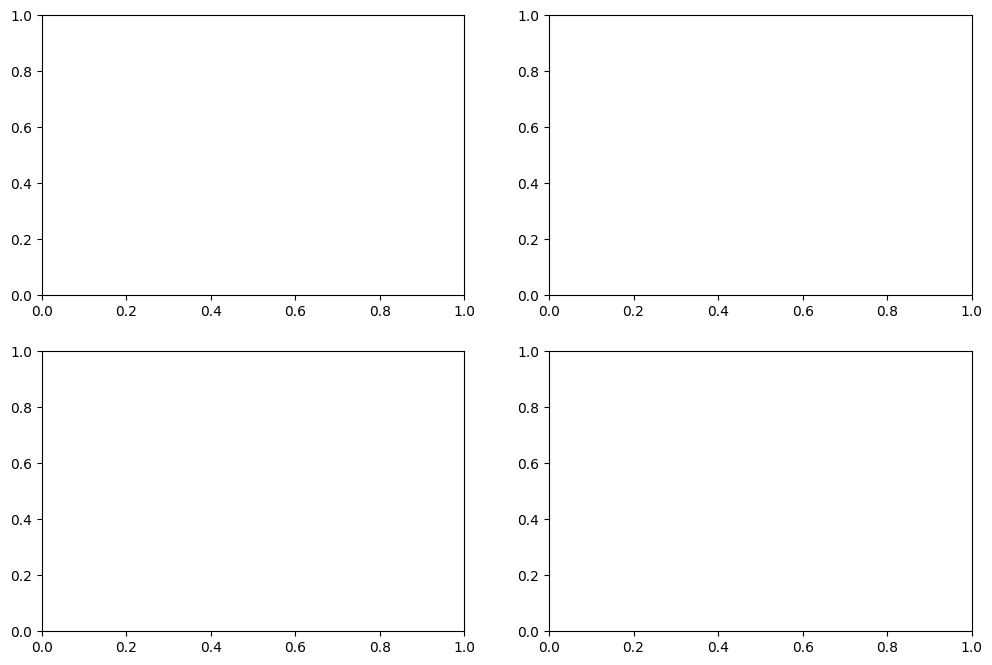

In [5]:
ALL_FILES = [
    "2950_spike_mat_or_rand", #26
    "2953_spike_mat_or_rand", #Tal paper
    "2957_spike_mat_or_rand",
    "5116_spike_mat_or_rand",
]
# Load your .mat file


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for idx, fn in enumerate(ALL_FILES):
    data = loadmat(f"{fn}.mat")

    # Extracting all variables from the .mat file
    t_spk_mat = data['t_spk_mat']
    neuron = t_spk_mat[:, 0].astype(np.float32)
    xs = np.linspace(0, len(spike_indices), len(spike_indices)) / 1000.0
    spike_indices = neuron[:30*1000]
    spike_indices_gaussian = gaussian_filter1d(spike_indices, 100)


    ax = axs[idx // 2, idx % 2]
    ax.plot(xs, spike_indices_gaussian, label='Gaussian', color='red')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Instantaneous firing rate', color='red')
    ax.set_title(f"Raster Plot for {fn}")
    ax2 = ax.twinx()
    ax2.plot(xs, spike_indices, label='Original', alpha=0.5)
    ax2.set_ylabel('Neuron Activity')
    
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


    
    
  
    # plt.plot(xs, spike_indices)
    #.nonzero()
    # print(spike_indices)
    # plt.scatter(spike_indices[0] / 1000.0, spike_indices[1], marker='|', s=10)
    # plt.set_xlabel('Time (seconds)')
    # ax.set_ylabel('Sorted unit ID')
    # ax.set_title(f"Raster Plot for {fn}")
   
        

    
    

 



   



1. (no window) In order to choose threshold for the correlations, we need to make a histogram for each of the organoids data sets
ALL_FILES = [
    "2950_spike_mat_or_rand", #26
    "2953_spike_mat_or_rand", #Tal paper
    "2957_spike_mat_or_rand",
    "5116_spike_mat_or_rand",
]

We want to keep the tail representing the highest correlations

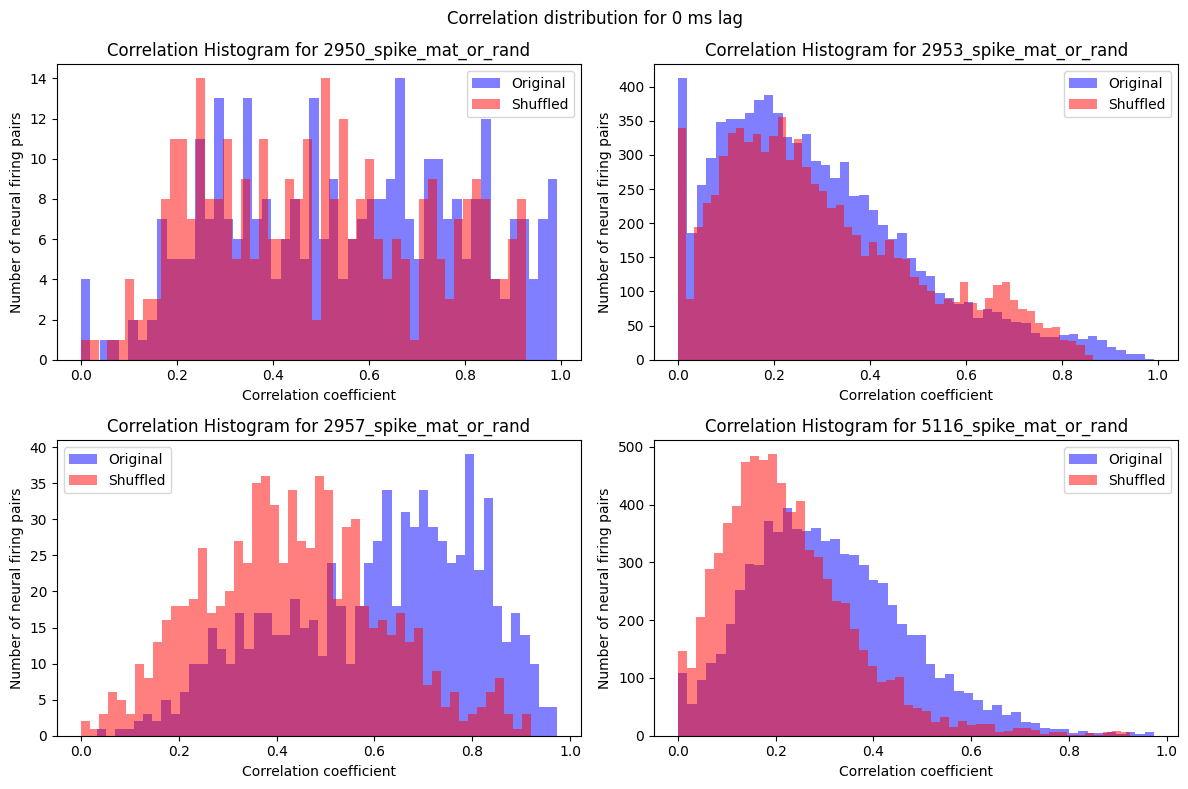

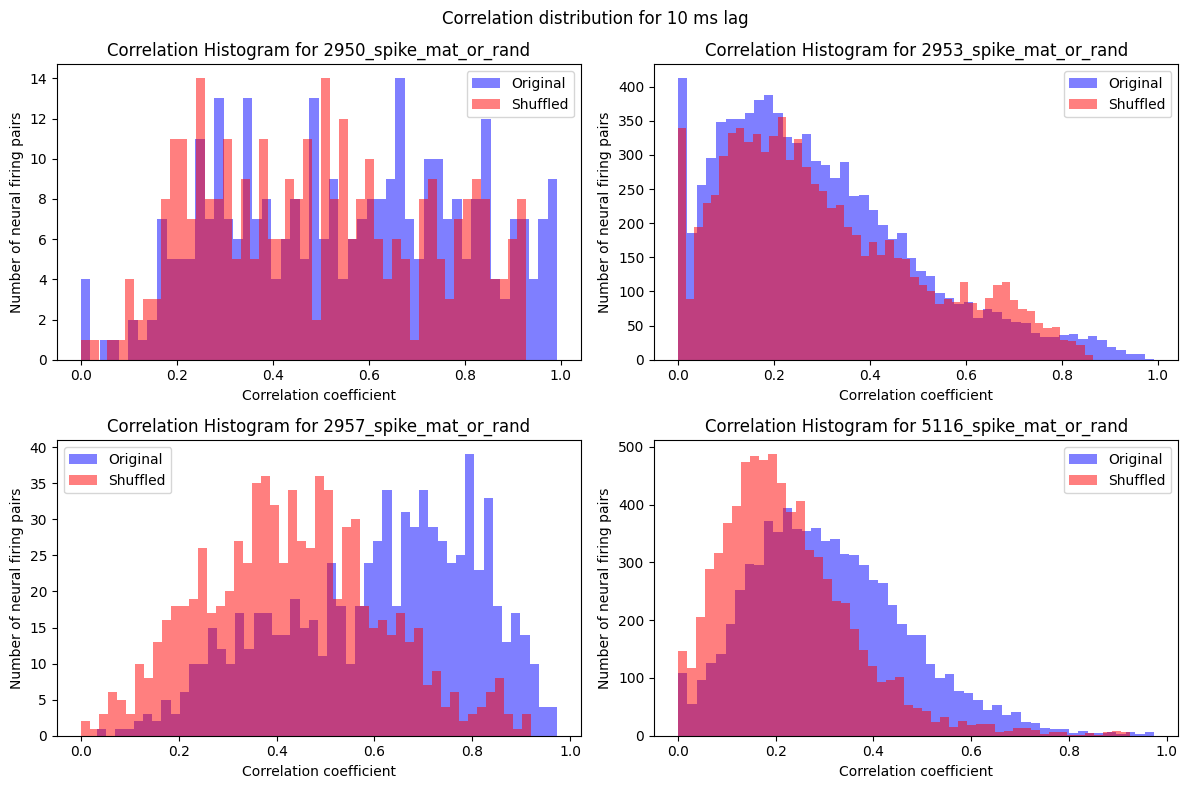

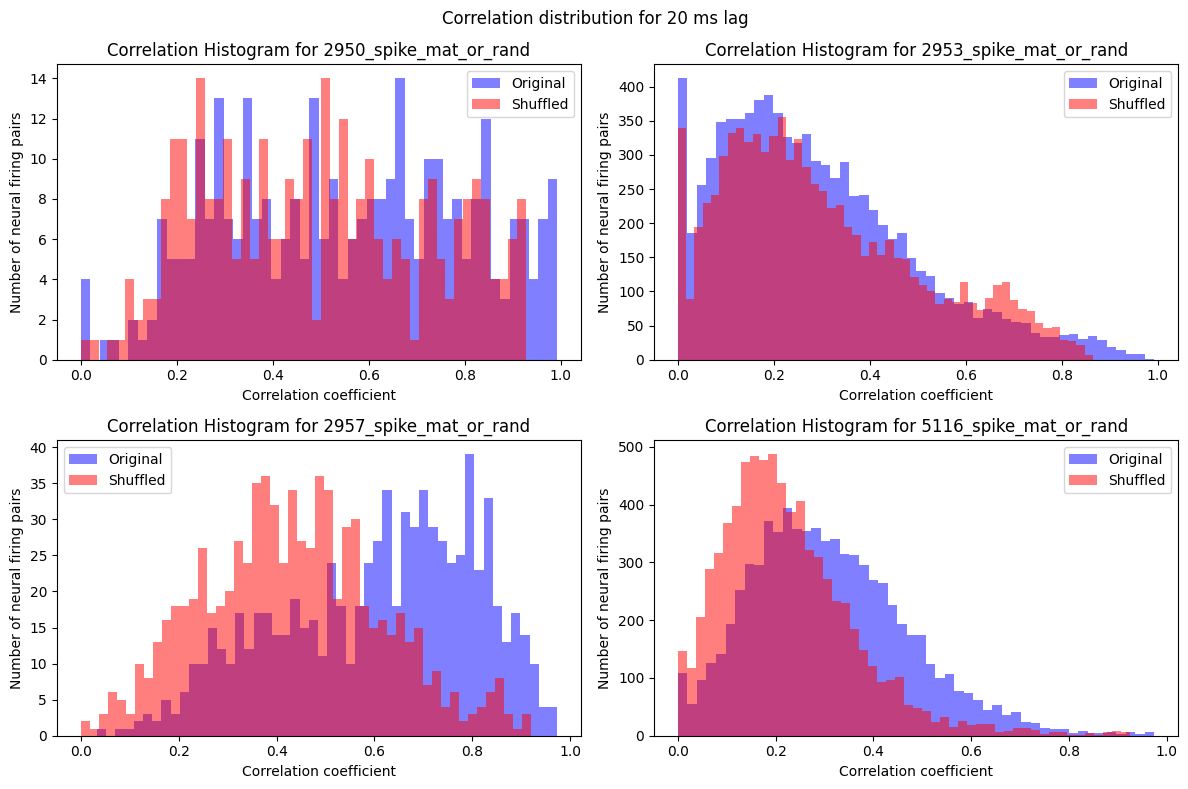

In [25]:
import pickle

for lag in [0, 10, 20]:
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"Correlation distribution for {lag} ms lag")
    for idx, fn in enumerate(ALL_FILES):
        with open(f"processed/{fn}_lag_window_0.pkl", "rb") as f:
            data = pickle.load(f)
        with open(f"processed/{fn}_lag_window_0_shuffle.pkl", "rb") as f:
            data_shuffled = pickle.load(f)
        ax = axs[idx // 2, idx % 2]
        idx = np.triu_indices(data["corr"].shape[0], 1)
        ax.hist(data["corr"][idx], bins=50, alpha=0.5, label="Original", color='blue')
        ax.hist(data_shuffled["corr"][idx], bins=50, alpha=0.5, label="Shuffled", color='red')
        ax.set_xlabel("Correlation coefficient")  # Add x-axis title
        ax.set_ylabel("Number of neural firing pairs")  # Add x-axis title
        ax.set_title(f"Correlation Histogram for {fn}")  # Add title with fn
        ax.legend()
    fig.tight_layout()
    plt.show()
    

2. (no window)Take the highest correlations tail from step 1. and construct a network for that taken tail where

- node are neural firing rates (one node is 1-2-1 firing rate): one row of the initial matrix
- edge are correlation coefficients 

Result will be four networks for each of highest correlated tail in the given data sets

3. (no window) Perform hole analyzis for the network from Step 2. 

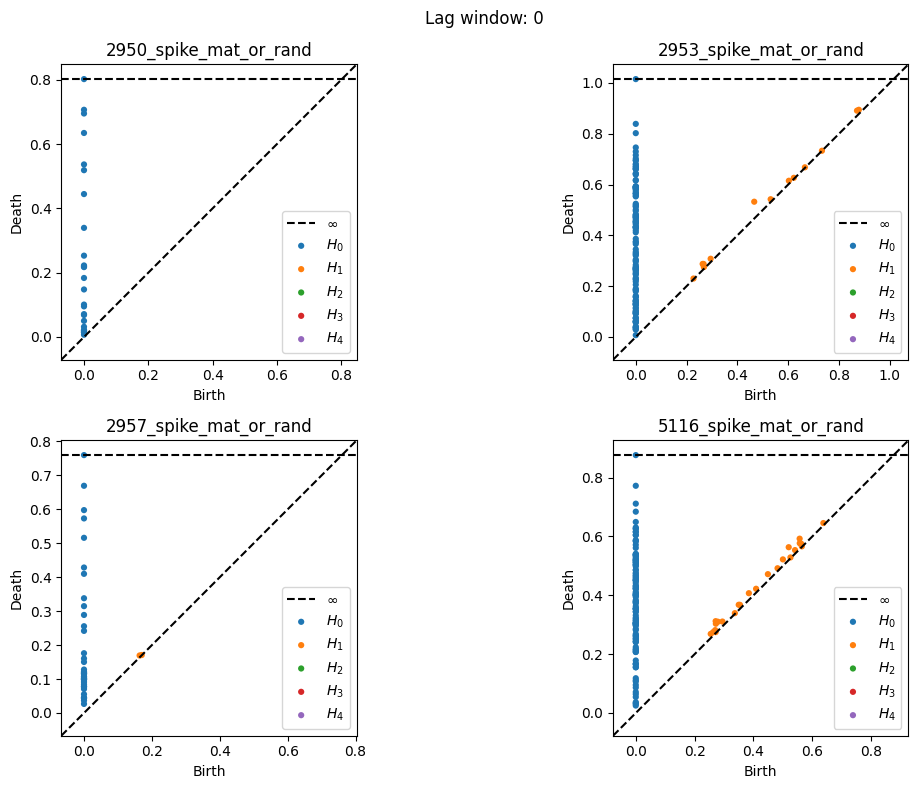

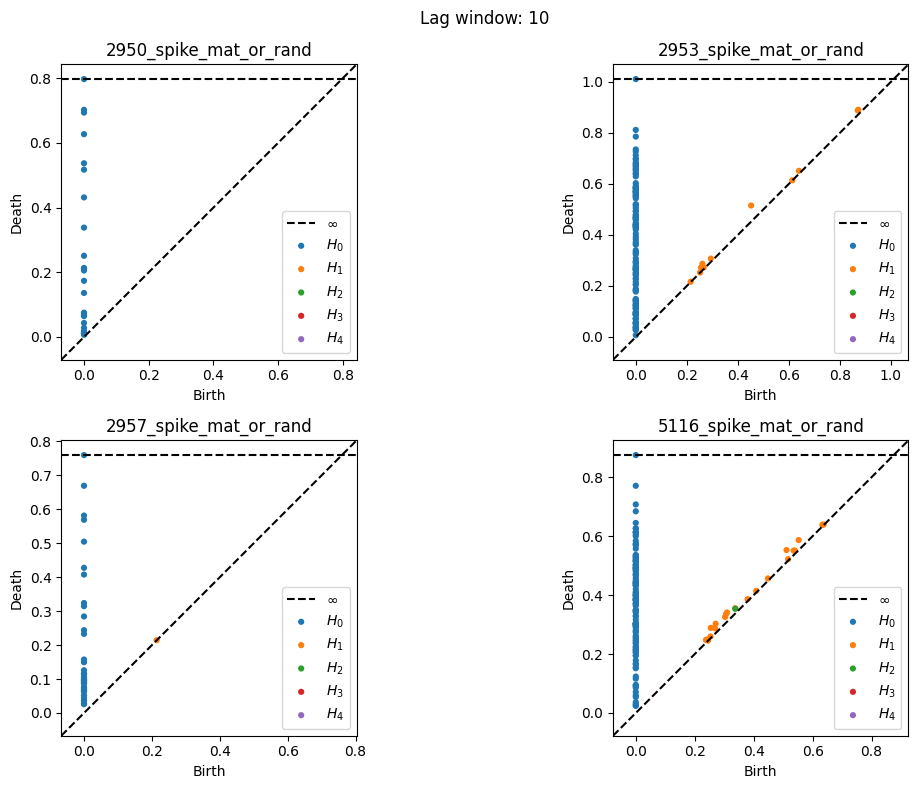

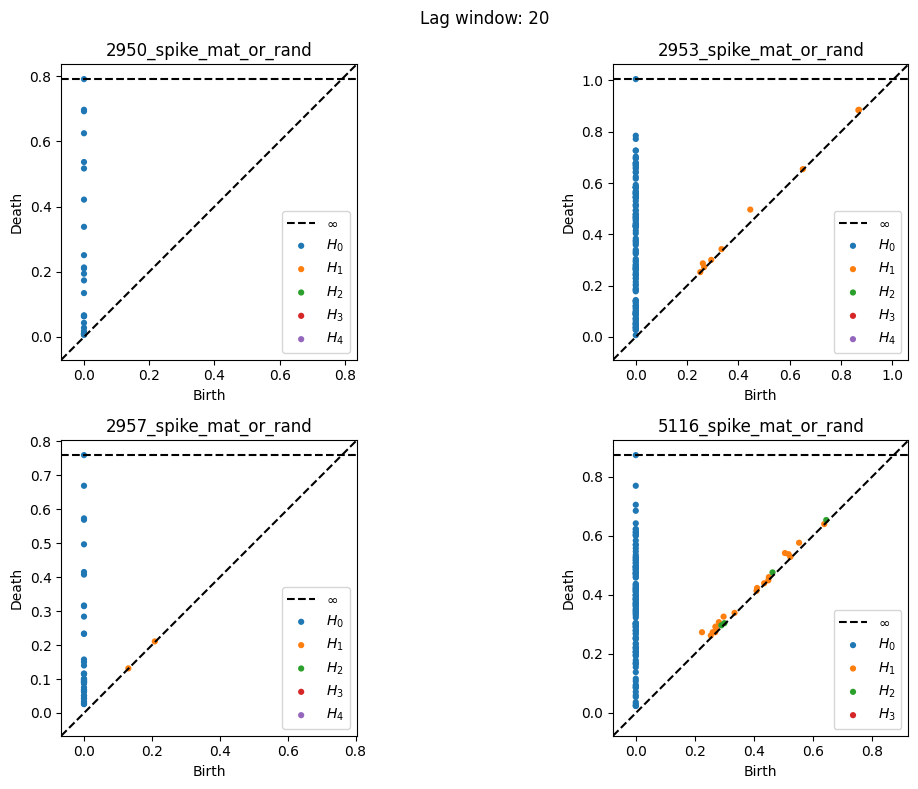

In [19]:
from ripser import ripser
from persim import plot_diagrams

for lag in [0, 10, 20]:
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"Lag window: {lag}")
    for idx, fn in enumerate(ALL_FILES):
        with open(f"processed/{fn}_lag_window_{lag}.pkl", "rb") as f:
            data = pickle.load(f)
        plot_diagrams(data["ripser"]["dgms"], ax=axs[idx // 2, idx % 2], show=False, title=f"{fn}")
    fig.tight_layout()
    plt.show()

3. Repeat step 1 and step 2 and step 3 for lag window 10 ms

[123, 25, 0, 0]

4. Repeat step 1 and step 2 and step 3for lag window 20 ms